In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn import svm, ensemble
from sklearn.ensemble import AdaBoostRegressor
import time
import matplotlib.pyplot as plt

weather = pd.read_csv('data/weather.csv')
pallet_history = pd.read_csv('data/Pallet_history_Gold_Spike.csv')
inbound = pd.read_csv('data/inbound_loads.csv')
outbound = pd.read_csv('data/outbound_laods.csv')
demand = pd.read_csv('data/demand_kWtrain_val.csv')

# Preprocessing the csv files

In [17]:
#################
# Preprocess inbound csv:
#################
print('\n #####\nInbound: \n ##### \n')
inbound_post = inbound[inbound.carrier_code != 'CANCEL']
inbound_post = inbound[inbound.carrier_code != '']

inbound_post['truck_signin_datetime'] = pd.to_datetime(inbound_post['truck_signin_datetime'])

# Compute delta times
inbound_load_time = pd.to_datetime(inbound_post['load_finish_datetime']) - pd.to_datetime(inbound_post['load_start_datetime'])
inbound_truck_time = pd.to_datetime(inbound_post['truck_signin_datetime']) - pd.to_datetime(inbound_post['signout_datetime'])

# Drop unnecessary columns
inbound_post = inbound_post.drop(['Unnamed: 0', 'warehouse_order_number', 'customer_code', 'load_reference_number', 'carrier_code', 'weight_uom', 'load_finish_datetime', 'load_start_datetime', 'dock_door_number', 'trailer_number', 'signout_datetime'], axis=1)

# Add time deltas
inbound_post['load_time'] = inbound_load_time
inbound_post['truck_time'] = inbound_truck_time

print(inbound_post.columns)

inbound_post['load_time'] = inbound_post['load_time'].dt.seconds
inbound_post['truck_time'] = inbound_post['truck_time'].dt.seconds

print('With NaN:', inbound_post.shape)

# Drop rows with >0 NaN values
inbound_post_nan = inbound_post.dropna().reset_index(drop=True)

print('Without NaN:', inbound_post_nan.shape)

#################
# Preprocess outbound csv:
#################
print('\n #####\nOutbound: \n ##### \n')
outbound_post = outbound[outbound.carrier_code != 'CANCEL']
outbound_post = outbound[outbound.carrier_code != 'VOID']
outbound_post = outbound[outbound.carrier_code != '']

outbound_post['truck_signin_datetime'] = pd.to_datetime(outbound_post['truck_signin_datetime'])

# Compute delta times
outbound_load_time = pd.to_datetime(outbound_post['load_finish_datetime']) - pd.to_datetime(outbound_post['load_start_datetime'])
outbound_truck_time = pd.to_datetime(outbound_post['truck_signin_datetime']) - pd.to_datetime(outbound_post['signout_datetime'])

# Drop unnecessary columns
outbound_post = outbound_post.drop(['Unnamed: 0', 'warehouse_order_number', 'customer_code', 'load_reference_number', 'carrier_code', 'weight_uom', 'load_finish_datetime', 'load_start_datetime', 'dock_door_number', 'trailer_number', 'signout_datetime'], axis=1)

# Add time deltas
outbound_post['load_time'] = outbound_load_time
outbound_post['truck_time'] = outbound_truck_time

print(outbound_post.columns)

outbound_post['load_time'] = outbound_post['load_time'].dt.seconds
outbound_post['truck_time'] = outbound_post['truck_time'].dt.seconds

print('With NaN:', outbound_post.shape)

# Drop rows with >0 NaN values
outbound_post_nan = outbound_post.dropna().reset_index(drop=True)

print('Without NaN:', outbound_post_nan.shape)

#################
# Preprocess demand csv:
#################
print('\n #####\nDemand:  \n ##### \n')

demand['datetime_local'] = pd.to_datetime(demand['datetime_local'])

end_known_idx = demand[demand.demand_kW > 1].index[-1]
train_val_split = 0.7 # 70% train, 30% val
end_train_idx = int((train_val_split) * end_known_idx)
demand_train = demand.loc[0:end_train_idx-1]
demand_val = demand.loc[end_train_idx:end_known_idx]
demand_test = demand.iloc[end_known_idx:-2]

print('Full dataset:', demand.shape)
print('Answers known until index: ', end_known_idx)
print(f'Training set, {int(train_val_split*100)}%:', demand_train.shape)
print(f'Validation set, {int(100-train_val_split*100)}%:', demand_val.shape)
print('Test set', demand_test.shape)

#################
# Preprocess weather csv:
#################
print('\n #####\nWeather:  \n ##### \n')

weather_post = weather.copy()
UTC6 = pd.to_datetime(weather_post['datetime_UTC']) - pd.Timedelta(hours=6)
weather_post['datetime_america'] = UTC6
weather_post = weather_post.drop('datetime_UTC', axis=1)
weather_post = weather_post.drop(['datetime', 'hour', 'Unnamed: 0'], axis=1)

print(weather_post.head())
print(weather_post.columns)
print(weather_post.shape)



 #####
Inbound: 
 ##### 

Index(['front_temperature', 'middle_temperature', 'back_temperature',
       'net_weight', 'case_quantity', 'pallet_count', 'truck_signin_datetime',
       'load_time', 'truck_time'],
      dtype='object')
With NaN: (56146, 9)
Without NaN: (8761, 9)

 #####
Outbound: 
 ##### 

Index(['net_weight', 'case_quantity', 'pallet_count', 'truck_signin_datetime',
       'load_time', 'truck_time'],
      dtype='object')
With NaN: (112363, 6)
Without NaN: (96704, 6)

 #####
Demand:  
 ##### 

Full dataset: (365349, 3)
Answers known until index:  273987
Training set, 70%: (191790, 3)
Validation set, 30%: (82198, 3)
Test set (91360, 3)

 #####
Weather:  
 ##### 

   Relative Humidity  Temperature    datetime_america
0              50.37         53.6 2018-12-31 18:00:00
1              50.37         53.6 2018-12-31 18:05:00
2              50.37         53.6 2018-12-31 18:10:00
3              50.37         53.6 2018-12-31 18:15:00
4              50.37         53.6 2018-12-31

# Merging csv files

### Inbound with demand:

In [3]:
import datetime
inbound_post_nan.sort_values("truck_signin_datetime", inplace=True)
print("inbound", inbound_post_nan.shape)
print("demand", demand_train.shape)
demand_inbound_merge = pd.merge_asof(demand_train, inbound_post_nan, left_on='datetime_local', right_on='truck_signin_datetime', direction='nearest', tolerance=datetime.timedelta(minutes = 15))
# Do we keep every demand datapoint? We should not get rid of those.
# We get rid of every datapoint that is > 15 mins difference between demand_train 'datetime_local' and inbound_post_nan 'truck_signin_time'
demand_inbound_merge = demand_inbound_merge.dropna().reset_index(drop=True)

demand_inbound_merge_numerical = demand_inbound_merge.copy()
demand_inbound_merge_numerical['datetime_local'] = demand_inbound_merge_numerical['datetime_local'].apply(lambda x: time.mktime(x.timetuple()))
demand_inbound_merge_numerical['truck_signin_datetime'] = demand_inbound_merge_numerical['truck_signin_datetime'].apply(lambda x: time.mktime(x.timetuple()))

print("demand+inbound", demand_inbound_merge_numerical.shape)

demand_inbound_merge_numerical.set_index('datetime_local', inplace=True)
demand_inbound_merge_numerical = demand_inbound_merge_numerical.drop(['Unnamed: 0','truck_signin_datetime'], axis=1)


demand_inbound_merge_numerical.head(5)

inbound (8761, 9)
demand (191789, 3)
demand+inbound (8574, 12)


,demand_kW,front_temperature,middle_temperature,back_temperature,net_weight,case_quantity,pallet_count,load_time,truck_time
datetime_local,,,,,,,,,
1.546372e+09,1930.286690,3.0,3.0,1.0,45672.0,1458.0,24.0,300.0,86395.0
1.546373e+09,2050.874792,3.0,5.0,7.0,46080.0,1440.0,24.0,360.0,86399.0
1.546374e+09,2005.786278,3.0,4.0,3.0,26324.0,4500.0,30.0,960.0,86399.0
1.546402e+09,1865.213656,3.0,3.0,4.0,41070.0,3344.0,25.0,1260.0,81264.0
1.546403e+09,1925.543624,3.0,3.0,4.0,41070.0,3344.0,25.0,1260.0,81264.0


### Outbound with demand

In [4]:
outbound_post_nan.sort_values("truck_signin_datetime", inplace=True)
print("outbound", outbound_post_nan.shape)
print("demand", demand_train.shape)
demand_outbound_merge = pd.merge_asof(demand_train, outbound_post_nan, left_on='datetime_local', right_on='truck_signin_datetime', direction='nearest', tolerance=datetime.timedelta(minutes = 15))
# AGain, only merge when time is within 15 minutes difference between demand_train and outbound_post_nan
demand_outbound_merge = demand_outbound_merge.dropna().reset_index(drop=True)

print("demand+outbound", demand_outbound_merge.shape)

demand_outbound_merge_numerical = demand_outbound_merge.copy()
demand_outbound_merge_numerical['datetime_local'] = demand_outbound_merge_numerical['datetime_local'].apply(lambda x: time.mktime(x.timetuple()))
demand_outbound_merge_numerical['truck_signin_datetime'] = demand_outbound_merge_numerical['truck_signin_datetime'].apply(lambda x: time.mktime(x.timetuple()))

demand_outbound_merge_numerical.set_index('datetime_local', inplace=True)
demand_outbound_merge_numerical = demand_outbound_merge_numerical.drop(['Unnamed: 0','truck_signin_datetime'], axis=1)

demand_outbound_merge_numerical.head(5)

outbound (96704, 6)
demand (191789, 3)
demand+outbound (102660, 9)


,demand_kW,net_weight,case_quantity,pallet_count,load_time,truck_time
datetime_local,,,,,,
1.546375e+09,1922.870566,12563.00,4.0,4.0,32.0,52740.0
1.546376e+09,2034.407233,26960.00,621.0,15.0,3499.0,51762.0
1.546385e+09,1699.962288,14998.75,2378.0,27.0,7351.0,71406.0
1.546386e+09,1948.080230,14998.75,2378.0,27.0,7351.0,71406.0
1.546397e+09,2067.256711,33395.00,3281.0,60.0,3395.0,77854.0


### Adding weather

In [5]:
weather_numerical = weather_post.copy()
weather_numerical['datetime_america'] = weather_numerical['datetime_america'].apply(lambda x: time.mktime(x.timetuple()))
weather_numerical.sort_values("datetime_america", inplace=True)
weather_numerical.set_index('datetime_america', inplace=True)

demand_inbound = demand_inbound_merge_numerical.copy()
demand_inbound.reset_index(inplace=True)
demand_inbound.sort_values("datetime_local", inplace=True)
weather_inbound_merge = pd.merge_asof(demand_inbound, weather_numerical, left_on='datetime_local', right_on='datetime_america', direction='nearest')
# todo add  tolerance=datetime.timedelta(minutes = 15) but for numerical differences :(

weather_inbound_merge.set_index('datetime_local', inplace=True)
print(weather_inbound_merge.shape)

weather_inbound_merge.head()

(8574, 11)


,demand_kW,front_temperature,middle_temperature,back_temperature,net_weight,case_quantity,pallet_count,load_time,truck_time,Relative Humidity,Temperature
datetime_local,,,,,,,,,,,
1.546372e+09,1930.286690,3.0,3.0,1.0,45672.0,1458.0,24.0,300.0,86395.0,74.60,33.8
1.546373e+09,2050.874792,3.0,5.0,7.0,46080.0,1440.0,24.0,360.0,86399.0,74.60,33.8
1.546374e+09,2005.786278,3.0,4.0,3.0,26324.0,4500.0,30.0,960.0,86399.0,74.60,33.8
1.546402e+09,1865.213656,3.0,3.0,4.0,41070.0,3344.0,25.0,1260.0,81264.0,86.26,30.2
1.546403e+09,1925.543624,3.0,3.0,4.0,41070.0,3344.0,25.0,1260.0,81264.0,86.26,30.2


In [6]:
demand_outbound = demand_outbound_merge_numerical.copy()
demand_outbound.reset_index(inplace=True)
demand_outbound.sort_values("datetime_local", inplace=True)
weather_outbound_merge = pd.merge_asof(demand_outbound, weather_numerical, left_on='datetime_local', right_on='datetime_america', direction='nearest')

weather_outbound_merge.set_index('datetime_local', inplace=True)
print(weather_outbound_merge.shape)

weather_outbound_merge.head()

(102660, 8)


,demand_kW,net_weight,case_quantity,pallet_count,load_time,truck_time,Relative Humidity,Temperature
datetime_local,,,,,,,,
1.546375e+09,1922.870566,12563.00,4.0,4.0,32.0,52740.0,74.60,33.8
1.546376e+09,2034.407233,26960.00,621.0,15.0,3499.0,51762.0,74.60,33.8
1.546385e+09,1699.962288,14998.75,2378.0,27.0,7351.0,71406.0,80.19,32.0
1.546386e+09,1948.080230,14998.75,2378.0,27.0,7351.0,71406.0,80.19,32.0
1.546397e+09,2067.256711,33395.00,3281.0,60.0,3395.0,77854.0,86.26,30.2


In [17]:
inbound = weather_inbound_merge.copy()
outbound = weather_outbound_merge.copy()

Removing the date columns, because their magnitude may be interfering with the regression.

MSE 99402.81427005671


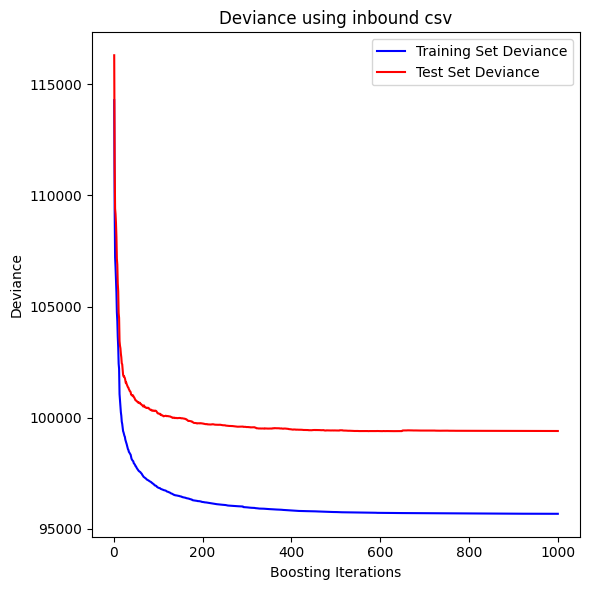

In [24]:
# Split the data into training and test sets
nonan = inbound.dropna().reset_index(drop=True)
X = nonan.drop('demand_kW', axis=1)
y = nonan['demand_kW']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set up pipeline parameters
params = {
    "n_estimators": 1000,
    "learning_rate": 1,
    "loss": "squared_error",
}
pipeline_inbound = ensemble.GradientBoostingRegressor(**params)
# Fit the pipeline to the training data
pipeline_inbound.fit(X_train, y_train)

# Predict on the test data
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(pipeline_inbound.staged_predict(X_test)):
    test_score[i] = mean_squared_error(y_test, y_pred)

y_pred = np.array(list(pipeline_inbound.staged_predict(X_test)))[-1]
data = {'y_pred': y_pred,
        'y_test': y_test}
print('MSE', mean_squared_error(y_test, y_pred))

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance using inbound csv")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    pipeline_inbound.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

MSE outbound 59338.79521169139


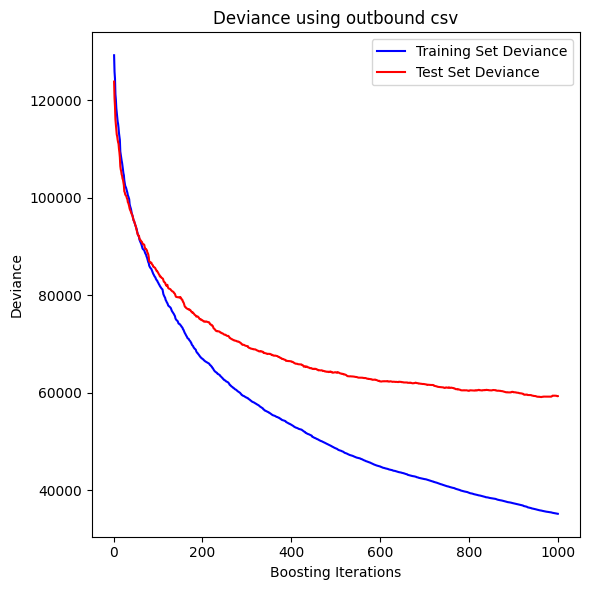

In [19]:
# Split the data into training and test sets
nonan = outbound.dropna().reset_index(drop=True)
X = nonan.drop('demand_kW', axis=1)
y = nonan['demand_kW']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set up pipeline parameters
params = {
    "n_estimators": 1000,
    "learning_rate": 1,
    "loss": "squared_error",
}
pipeline_outbound = ensemble.GradientBoostingRegressor(**params)
# Fit the pipeline to the training data
pipeline_outbound.fit(X_train, y_train)

# Predict on the test data
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(pipeline_outbound.staged_predict(X_test)):
    test_score[i] = mean_squared_error(y_test, y_pred)

y_pred = np.array(list(pipeline_outbound.staged_predict(X_test)))[-1]
data = {'y_pred': y_pred,
        'y_test': y_test}
print('MSE outbound', mean_squared_error(y_test, y_pred))

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance using outbound csv")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    pipeline_outbound.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

Prediction on test set

In [22]:
X = demand_test.drop('demand_kW', axis=1)
y = demand_test['demand_kW']

# Predict on the test data using inbound-trained model
y_pred_inbound = np.array(list(pipeline_inbound.staged_predict(demand_test)))[-1]

# Predict on the test data using outbound-trained model
y_pred_outbound = np.array(list(pipeline_outbound.staged_predict(demand_test)))[-1]

y_pred_merged = (y_pred_inbound+y_pred_outbound)/2

# Merge predictions
data = {'y_pred_inbound': y_pred_inbound,
        'y_pred_outbound': y_pred_outbound,
        'y_pred_merged': y_pred_merged}

df_test_total = pd.DataFrame(data)
df_test_total.to_csv('output/test_perf_inbound_outbound_merged.csv', index=False)


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Unnamed: 0
- datetime_local
- demand_kW
Feature names seen at fit time, yet now missing:
- Relative Humidity
- Temperature
- back_temperature
- case_quantity
- front_temperature
- ...


MSE inbound 55821.64902901732


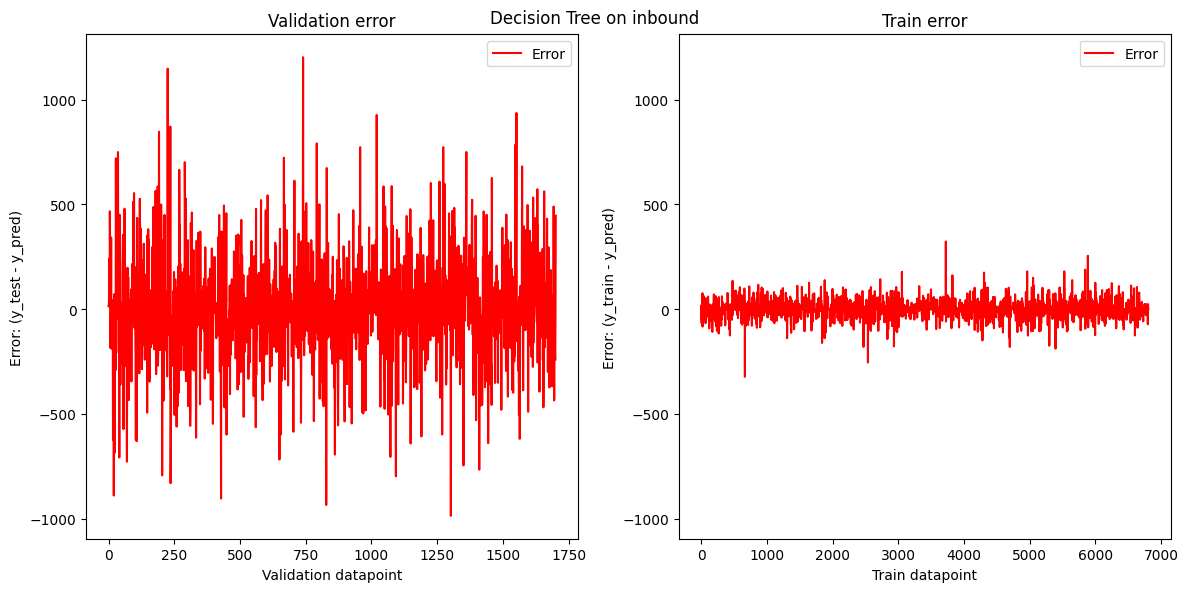

In [10]:
# Decision Tree
from sklearn import tree
pipeline = tree.DecisionTreeRegressor()
# Fit the pipeline to the training data

# Split the data into training and test sets
nonan = inbound.dropna().reset_index(drop=True)
X = nonan.drop('demand_kW', axis=1)
y = nonan['demand_kW']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)

y_pred = np.array(list(pipeline.predict(X_test)))
data = {'y_pred': y_pred,
        'y_test': y_test}
df = pd.DataFrame(data)
# df.to_csv('output/validation_predictions_decisiontree.csv', index=False)
print('MSE inbound', mean_squared_error(y_test, y_pred))

# Show Error on Validation Set
fig = plt.figure(figsize=(12, 6))
ax1 = plt.subplot(1, 2, 1)
plt.title("Validation error")
plt.plot(np.arange(len(y_pred)), y_test - y_pred, "r-", label="Error")
plt.legend(loc="upper right")
plt.xlabel("Validation datapoint")
plt.ylabel("Error: (y_test - y_pred)")

# Show Error on Training Set
y_pred = np.array(list(pipeline.predict(X_train)))
ax2 = plt.subplot(1, 2, 2, sharey = ax1)
plt.title("Train error")
plt.plot(np.arange(len(y_pred)), y_train - y_pred, "r-", label="Error")
plt.legend(loc="upper right")
plt.xlabel("Train datapoint")
plt.ylabel("Error: (y_train - y_pred)")
fig.tight_layout()
plt.suptitle("Decision Tree on inbound")
plt.show()

MSE outbound 62470.90132210552


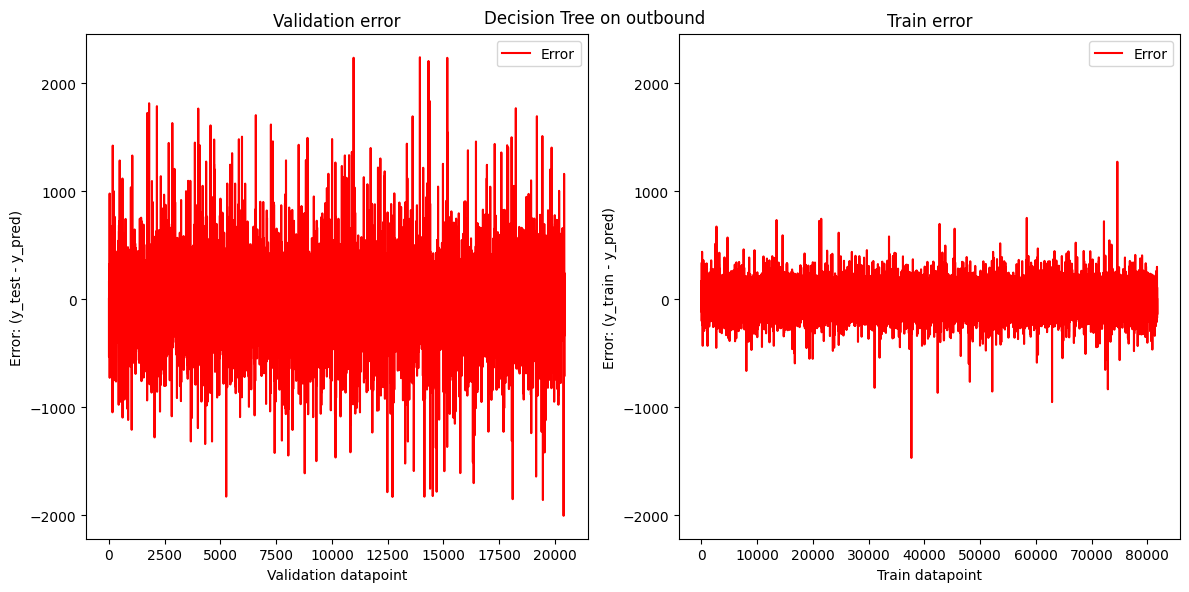

In [11]:
# Split the data into training and test sets
nonan = outbound.dropna().reset_index(drop=True)
X = nonan.drop('demand_kW', axis=1)
y = nonan['demand_kW']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)

y_pred = np.array(list(pipeline.predict(X_test)))
data = {'y_pred': y_pred,
        'y_test': y_test}
df = pd.DataFrame(data)
# df.to_csv('output/validation_predictions_decisiontree.csv', index=False)
print('MSE outbound', mean_squared_error(y_test, y_pred))

# Show Error on Validation Set
fig = plt.figure(figsize=(12, 6))
ax1 = plt.subplot(1, 2, 1)
plt.title("Validation error")
plt.plot(np.arange(len(y_pred)), y_test - y_pred, "r-", label="Error")
plt.legend(loc="upper right")
plt.xlabel("Validation datapoint")
plt.ylabel("Error: (y_test - y_pred)")

# Show Error on Training Set
y_pred = np.array(list(pipeline.predict(X_train)))
ax2 = plt.subplot(1, 2, 2, sharey = ax1)
plt.title("Train error")
plt.plot(np.arange(len(y_pred)), y_train - y_pred, "r-", label="Error")
plt.legend(loc="upper right")
plt.xlabel("Train datapoint")
plt.ylabel("Error: (y_train - y_pred)")
fig.tight_layout()
plt.suptitle("Decision Tree on outbound")
plt.show()